# Data Quality

This notebook shows some of the data quality functions associated with a 
[Spectrum](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum) .
The data used for this example is taken from position switched observations of NGC5291 at 21 cm (AGBT05B_047_01) that 
we discussed in previous notebooks.

## Dysh commands

The following 
[Spectrum](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum)
functions will be discussed:


* [stats](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.stats)
  : statistics of a spectrum
* [roll](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.roll)
  : subtract the data by its rolled version to discover channel correlations and/or ripples in the spectrum
* [radiometer](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.radiometer)
  : adherence of spectrum to the radiometer equation
* [normalness](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.normalness)
  : p-value for null hypothesis that the data comes from a normal distribution
* [snr](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.snr)
  : signal-to-noise ratio, either channel or flux based
* [sratio](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.sratio)
  : flux ratio, a number between -1 and 1, if there is signal, 0 if none
* [cog](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.cog)
  : curve of growth
  
## Loading Modules

We start by loading the modules we will use in this notebook. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl # Uncomment for interactive plots.

# These modules are required for the data reduction.
import numpy as np
from astropy import units as u
from dysh.util.files import dysh_data
from dysh.spectra.spectrum import Spectrum
from dysh.fits.gbtfitsload import GBTFITSLoad

from dysh.log import init_logging

## Setup
We start the dysh logging, so we get more information about what is happening.
This is only needed if working on a notebook.
If using the CLI through the ``dysh`` command, then logging is setup for you.

In [2]:
init_logging(2)

## Data Loading

We use the data from the tests for
[getps](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.GBTFITSLoad.getps)
(AGBT05B_047_01).
We load the data using 
[GBTFITSLoad](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.GBTFITSLoad),
and then its 
[summary](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.GBTFITSLoad.summary)
method to inspect its contents.

In [3]:
filename = dysh_data(test="getps")      # AGBT05B_047_01/AGBT05B_047_01.raw.acs
sdfits = GBTFITSLoad(filename)

20:46:40.512 I Resolving test=getps -> AGBT05B_047_01/AGBT05B_047_01.raw.acs/


In [4]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


## Data Reduction

First we extract a (time-averaged) spectrum from the first scan. 
If you recall from the 
[Position-Switched example](https://dysh.readthedocs.io/en/latest/tutorials/examples/positionswitch.html), 
both edges have some problems, and for the purpose of this we remove some edge channels by slicing the 
[Spectrum](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum).
We end by plotting the resulting 
[Spectrum](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum)
using channels for the x-axis.

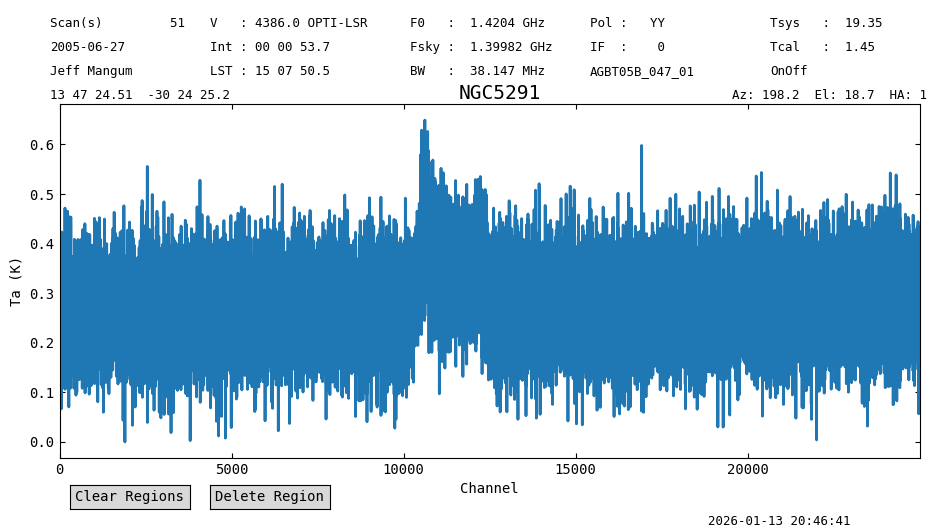

In [5]:
sp1 = sdfits.getps(scan=51, ifnum=0, plnum=0, fdnum=0).timeaverage()[5000:30000]
plot1 = sp1.plot(xaxis_unit='chan');

From the plot we see that there is a clear signal between channels 10000 and 13000.
We will need to avoid these channels in some of the examples below to reduce their impact on the computed data quality metrics.

## Statistics
We start by showing the use of the
[stats](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.stats) 
method.
This computes the mean, median, rms, mininum, maximum, number of points and number of points that are not-a-number (NaN).
We can compute these statistics over a subset of channels by slicing the 
[Spectrum](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum)
before calling the method.
We do this for the first 10000 channels and the last 10000 channels of the previously obtained spectrum, not the full 32768 channel spectrum.

In [6]:
# First 10,000 channels.
sp1[:10000].stats()

{'mean': <Quantity 0.26528672 K>,
 'median': <Quantity 0.26475095 K>,
 'rms': <Quantity 0.07121472 K>,
 'min': <Quantity 0.00017927 K>,
 'max': <Quantity 0.55562308 K>,
 'npt': 10000,
 'nan': 0}

In [7]:
# Last 10,000 channels.
sp1[-10000:].stats()

{'mean': <Quantity 0.28550266 K>,
 'median': <Quantity 0.28676712 K>,
 'rms': <Quantity 0.07194848 K>,
 'min': <Quantity 0.00420958 K>,
 'max': <Quantity 0.59789101 K>,
 'npt': 10000,
 'nan': 0}

There is a significant continuum visible in the spectrum, with a value of ${\approx}270$ mK, but the two sides differ a bit, in the sense there is slight increase towards higher channels. This is also visible in the previous plot.

The rms levels are very similar, at 0.0712 K and 0.0719 K respectively.

It is possible to compute the statistics over a "rolled" version of the spectrum.
That is, before computing the statistics, the values from channel `i+roll` are subtracted from the values of channel `i`.
This accomplished using the `roll` argument in the call to `stats`.
When using ``roll!=0`` the rms is divided by $\sqrt{2}$ to account for the subtraction.

In [8]:
print(sp1[:10000].stats(roll=2)["rms"])
print(sp1[-10000:].stats(roll=2)["rms"])

0.07129852614846216 K
0.07117563928812339 K


Here we see the rolled RMS is very similar to the direct RMS, a sign that there is little or no correlation between channels, and that there are no large scale variations in the baseline. This brings us to the next function, 
[roll](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.roll) :

## Roll

The 
[roll](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.roll)
method compares the rms in the spectrum to the rms obtained after "rolling" the data by `roll` channels.
This method is useful for assessing if there are channel-to-channel correlations. In the abscence of correlations the result should be close to unity. 
Correlations will drive the results away from unity.
However, the results from `roll` are also affected by slow variations in the data, as is the case with this spectrum.
We thus compare the first and second half.

In [9]:
sp1[:10000].roll(4)

[1.0135264176511074,
 0.9988245936948404,
 1.0009603161121046,
 1.0088321962353017]

In [10]:
sp1[-10000:].roll(4)

[0.9999156101763856,
 1.0108582257619612,
 1.0084001992327756,
 0.9975490040561179]

Here one can argue there is no correllation between channels, and there is little large scale variation in the baseline. Note we have not subtracted a baseline, so we will need to do this again later in the notebook.

##  Radiometer Equation

For a given $T_{sys}$, channel width $\Delta f$ and observing time $\Delta t$ the radiometer equation predicts the expected noise as:
$$
  \Delta T = {  { T_{sys} } \over \sqrt{ \Delta f \Delta t } }
$$
The 
[radiometer](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.radiometer) 
method will return the ratio of the measured noise to this expected noise.
In the abscence of artifacts, the result should be unity.
Deviations from unity might indicate that the noise properties do not follow those of a normal distribution.

For example, if we blindly compute this test we will get a value larger than one, because of line emission between channels 10000 and 13000.

In [11]:
sp1.radiometer()

1.1252550871340892

When we compute it on line-free channels the results are closer to unity.

In [12]:
print(sp1[:10000].radiometer(), sp1[-10000:].radiometer())

1.0534482472856417 1.0643024240081753


However, the measured noise (rms) is still ${\approx}6\%$ larger than expected.

For comparison, we compute this statistic in the case of a purely Gaussian signal.
We do this using the 
[fake_spectrum](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.fake_spectrum)
method, which returns a spectrum filled with Gaussian noise.

In [13]:
Spectrum.fake_spectrum(nchan=32768, seed=123).radiometer()

1.000493959432403

The exact value is a function of the number of channels in the spectrum, and it goes as $1/\sqrt{N}$. 
Experiments showed that for nchan=32768 the rms in this ratio is about 0.004.

## Normalness

The 
[normalness](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.normalness)
method gives the likelihood that the spectrum data is drawn from a normal distribution.
Under the hood this method computes the Anderson-Darling statistic and returns the p-value of the likelihood that the data is normally distributed.
A p-value larger than 0.05 indicates that the data is consistent with being drawn from a normal distribution.

We start by computing the normalness test for the line-free regions, and then we compute it for the whole spectrum.

In [14]:
print(sp1[:10000].normalness())
print(sp1[-10000:].normalness())

0.5988495760672907
0.3155802816898881


These values are larger than 0.05, so the line-free regions are consistent with Gaussian noise.
For amusement, the whole spectrum:

In [15]:
print(sp1.normalness())

2.577910207104425e-09


In this case the p-value is lower than 0.05, indicating that the null-hyphotesis can be rejected, that is, the data is not drawn from a normal distribution.
That is the case because of the line between channels 10000 and 13000.

## Baseline Subtraction

The remaining data quality tests, the signal-to-noise ratio and signal ratio, only make sense if the data has no continuum.
In this case that requires subtracting a baseline from the data.

We know that there is a line between channels 10000 and 13000, so we exclude these channels from the baseline fit using the `exclude` argument of 
[baseline](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.baseline) .
We saw earlier that there's a slope to the data, so we use a degree 2 polynomial for the baseline model, to to ensure any curvature is removed as well. Again, these things can later be tested.
We remove the best fit polynomial model from the data (`remove=True`).

In [16]:
sp1.baseline(degree=2, model="poly", exclude=[10000,13000], remove=True)

20:46:44.941 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1397351017.8086 Hz, 1401928654.52735 Hz) 
]


Plot the baseline subtracted spectrum and print its statistics.

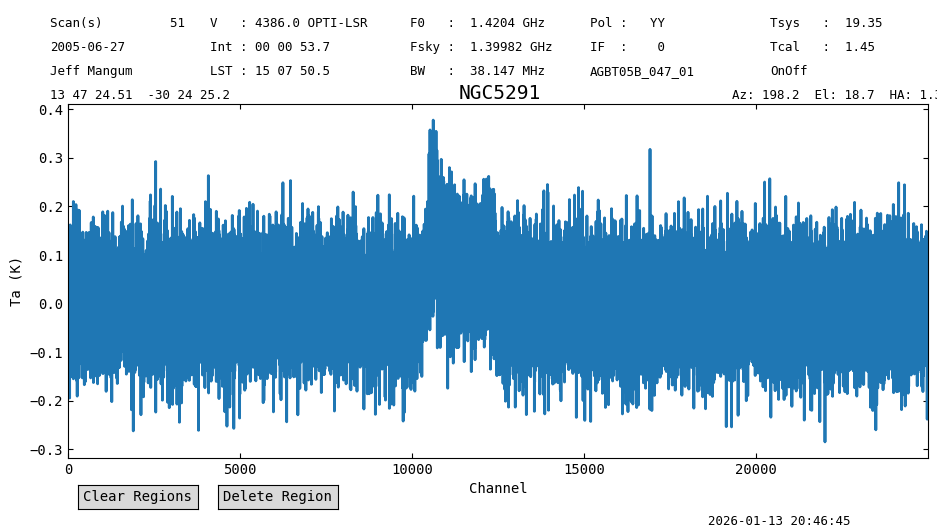

In [17]:
sp1.plot(xaxis_unit='chan');

In [18]:
sp1[:10000].stats()

{'mean': <Quantity -2.2629703e-05 K>,
 'median': <Quantity -0.00075626 K>,
 'rms': <Quantity 0.07116938 K>,
 'min': <Quantity -0.26237535 K>,
 'max': <Quantity 0.29259241 K>,
 'npt': 10000,
 'nan': 0}

In [19]:
sp1[-10000:].stats()

{'mean': <Quantity -0.00022584 K>,
 'median': <Quantity 0.00077847 K>,
 'rms': <Quantity 0.071728 K>,
 'min': <Quantity -0.28504302 K>,
 'max': <Quantity 0.31773396 K>,
 'npt': 10000,
 'nan': 0}

## snr: Signal-to-Noise Ratio

The 
[snr](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.snr)
method computes the signal-to-noise ratio of the spectrum.
This can be done in two ways: channel based and flux based.
For the latter a section of the spectrum where the signal is expected has to be selected.
For the channel based analysis, it will compute the ratio between the maximum value (``peak=True``, default) and the noise.
For an absorption signal one can use ``peak=False`` where the minimum is used instead.

For pure noise in a channel based comparision (the default) we would expect the signal-to-noise to be around 4, higher for higher number of channels, as can be computed via the error function.

In [20]:
print(sp1[:10000].snr(), sp1[-10000:].snr())

4.164491122535507 4.418897674363033


Now we repeat the ``snr`` call, but using the flux instead.
We show the results for the line-free regions of the spectrum and for the section with the line.

In [21]:
print(sp1[:10000].snr(flux=True))
print(sp1[-10000:].snr(flux=True))
print(sp1[10000:13000].snr(flux=True))

-0.03220654567185482
-0.3138716517831825
47.657354295385474


The line-free regions have a signal-to-noise of $<0.5$, so no signal in them.
Channels 10000 to 13000 have a signal-to-noise ratio of $47$. Really it should be called flux-to-error ratio.

Applying this to the whole spectrum, we still get a respectable ratio of over 5:

In [22]:
sp1.snr()

5.202717636938612

## sratio:  Signal Ratio

The 
[sratio](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.sratio)
(signal ratio) is defined as the sum between the positive and negative sum of the signals, normalized by the difference of both. This results in a dimensionless number between -1 and 1, where -1 means a pure absorption signal, 0 pure noise, and 1 pure emission line:
$$
     S_r = {{ P_{sum}+ N_{sum} } \over {P_{sum} - N_{sum}}}
$$
with $P_{sum}$ the sum of all the channels with positive values and $N_{sum}$ the sum of all the channels with negative values.
Note that $N_{sum}$ is negative.

We compute this for the line-free channels, where we expect values close to zero (no signal).

In [23]:
print(sp1[:10000].sratio())

-0.0003992688838904355


In [24]:
print(sp1[-10000:].sratio())

-0.003947589303452753


And now the channels with the line.

In [25]:
print(sp1[10000:13000].sratio())

0.7404518588445639


In this case we have a value of $0.74$, close to unity, indicating an emission line.

## Repeat statistics, roll and radiometer

Now that the spectrum has been baseline subtracted we can repeat the analysis carried out above.

In [26]:
# redo the tests
print(sp1[:10000].stats())
print(sp1[:10000].stats(roll=1))
print("ROLL",sp1[:10000].roll(4))


print(sp1[-10000:].stats())
print(sp1[-10000:].stats(roll=1))
print("ROLL",sp1[-10000:].roll(4))

{'mean': <Quantity -2.2629703e-05 K>, 'median': <Quantity -0.00075626 K>, 'rms': <Quantity 0.07116938 K>, 'min': <Quantity -0.26237535 K>, 'max': <Quantity 0.29259241 K>, 'npt': 10000, 'nan': 0}
{'mean': <Quantity -1.9197046e-06 K>, 'median': <Quantity -0.00102835 K>, 'rms': <Quantity 0.0702643 K>, 'min': <Quantity -0.37160137 K>, 'max': <Quantity 0.35925086 K>, 'npt': 9998, 'nan': 0}
ROLL [1.0128811828407966, 0.9981887192619758, 1.0003230836163932, 1.0081899537964756]
{'mean': <Quantity -0.00022584 K>, 'median': <Quantity 0.00077847 K>, 'rms': <Quantity 0.071728 K>, 'min': <Quantity -0.28504302 K>, 'max': <Quantity 0.31773396 K>, 'npt': 10000, 'nan': 0}
{'mean': <Quantity 1.49875702e-05 K>, 'median': <Quantity 7.22095017e-06 K>, 'rms': <Quantity 0.07195455 K>, 'min': <Quantity -0.36167572 K>, 'max': <Quantity 0.36903475 K>, 'npt': 9998, 'nan': 0}
ROLL [0.9968514887965323, 1.0077605734857915, 1.0053100806485058, 0.9944921396141728]


In [27]:
print(sp1[:10000].radiometer(), sp1[-10000:].radiometer())

1.0527775968231792 1.061040996560144


Curious how the radiometer equation holds as function of time?

In [28]:
for scan in [51,53,55,57]:
    sp2 = sdfits.getps(scan=scan, ifnum=0, plnum=0, fdnum=0).timeaverage()[5000:30000]
    print(scan, sp2[:10000].radiometer(), sp2[-10000:].radiometer())

51 1.0534482472856417 1.0643024240081753
53 1.0403504063163798 1.062509998615213
55 1.0583714835738989 1.0546632153917312
57 1.0434733004644334 1.05796537199034


So we can conclude it did not change behavior during this observation, but there is a clear 5-6% deviation from an ideal telescope.

## Smoothing

Smoothing should give us a much clearer detection.
We smooth the data using a Hanning kernel with a width of 50 channels.
Lets see how the previous measures live of to this task.

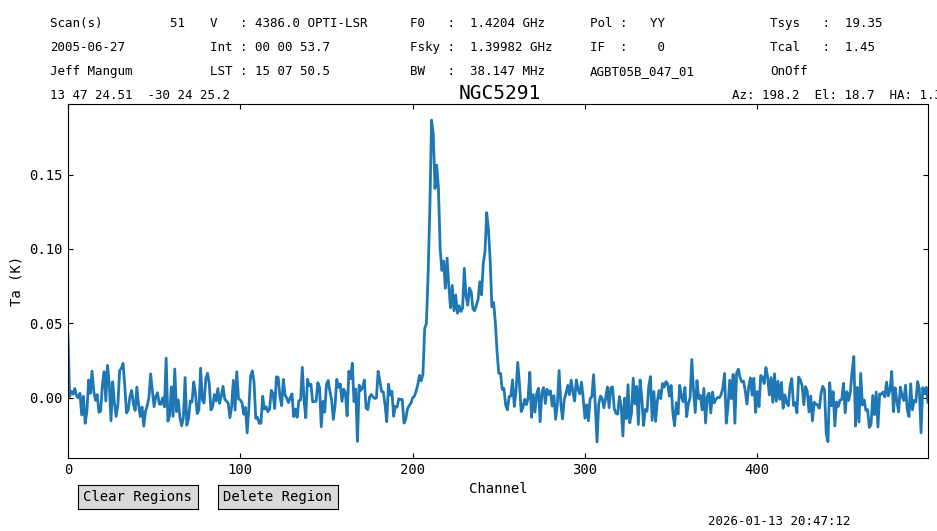

In [29]:
n = 50
method = 'hanning'
sp1s = sp1.smooth(method, n)

sp1s.plot(xaxis_unit='chan')

The line is now between channels 200 and 260.

Lets print the rms for this smoothed signal. 
Unsmoothed we found 0.07 K so we should expect $\sqrt{50}$ better, or about 0.01 K.

In [30]:
print(sp1s[:200].stats()["rms"], sp1s[-200:].stats()["rms"])

0.010752784789192019 K 0.010549863737707773 K


Smoothing reduced the noise as expected.

Now the radiometer equation test.

In [31]:
print(sp1s[:200].radiometer())
print(sp1s[-200:].radiometer())

1.1247328535675043
1.1035074707704637


In this case the test suggests that the data is worse than before (it was $5\%$ higher, now it is $11\%$).
This could be an artifact of ``dysh``, and is being investigated in issue 917

Now the signal-to-noise ratio.

In [32]:
print("Signal-to-Noise by channel")
print(sp1s[:200].snr(peak=True), sp1s[:200].snr(peak=False), 'left side')
print(sp1s[-200:].snr(peak=True), sp1s[-200:].snr(peak=False), 'right side')
print(sp1s[200:260].snr(peak=True), sp1s[200:260].snr(peak=False), 'central signal portion')

Signal-to-Noise by channel
4.484230544311227 3.015779809898705 left side
2.6415173359612636 2.798766349308014 right side
9.702435801524112 5.432312980009203 central signal portion


In [33]:
print("Signal-to-Noise by flux")
print(sp1s[:200].snr(flux=True), 'left side')
print(sp1s[-200:].snr(flux=True), 'right side')
print(sp1s[200:260].snr(flux=True), 'central signal portion')

Signal-to-Noise by flux
-0.15450025700694867 left side
-0.24202493616868073 right side
37.16940396132663 central signal portion


Notice that the signal-to-noise in the line intensity is now lower than before (it was ${\approx}47$).
That is because the ``snr`` method uses the data itself to determine the noise.
Since we are using a channel range that mostly contains signal, the noise estimate is higher, thus reducing the signal-to-noise ratio.
We can give our own estimate of the noise using the ``rms`` parameter when calling ``snr``.
Like

In [34]:
print(sp1s[200:260].snr(flux=True, rms=sp1s[-200:].stats()["rms"]), 'center signal portion with given rms')

45.34448717144942 center signal portion with given rms


This is closer to the previous estimate.
It also shows that smoothing the data does not improve the signal-to-noise ratio on the line intensity for this velocity resolved line.

And the signal ratio.

In [35]:
sp1s[200:260].sratio()

0.9898058269240652

a value very close to 1, so a clear signal.

This brings up the question of statistical significance. Unlike the `normalness()` function, we don't get a p-value out of this. We would have to compute this ourselves.

Without much more discussion, we offer the following experiment. Be aware, this cell can take a few minutes to compute depending on the value of `m`:

In [36]:
%%time 
m=1000                # number of experiments
d=np.zeros(m)         # array containing the sratio values
n=32768               # largest size of spectrum


for nchan in [n, n//4, n//4//4, n//4//4//4]:
    for i in range(m):
        sp = Spectrum.fake_spectrum(nchan=nchan, seed=i, use_wcs=False)  # no WCS to save time
        sp._data = sp._data - 0.1     # current fake_spectrum has hardcoded mean 0.1 - sp.data has no setter
        d[i] = sp.sratio()
    print(d.mean(),d.std(),nchan,m)

-0.00035908141241762005 0.006776663805880119 32768 1000
-0.0008523908785247654 0.013644333592073057 8192 1000
0.00032654409812803137 0.02752535025200927 2048 1000
0.0007357206161201921 0.056004749513986395 512 1000
CPU times: user 1min 55s, sys: 167 ms, total: 1min 55s
Wall time: 1min 55s


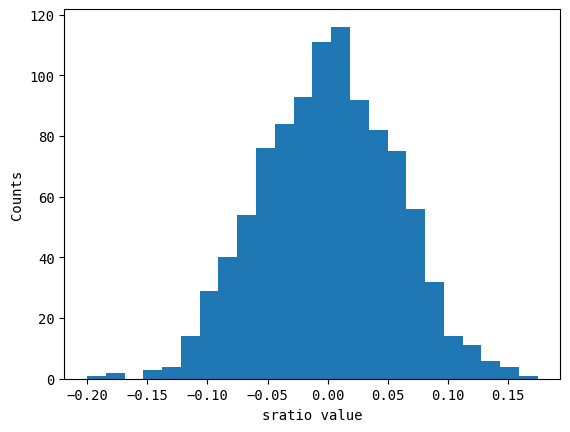

In [37]:
# plot histogram of last nchan loop with 512 channels
import matplotlib.pyplot as plt
plt.hist(d, bins="auto");
plt.xlabel("sratio value");
plt.ylabel("Counts");

The RMS follows the expected $1/\sqrt{N}$ behavior, and for given $N$ one can assign a p-value based on the error function if this distribution is normal.  We leave this as an excersize for the reader.

## Curve of Growth

The [Curve of Growth method](https://dysh.readthedocs.io/en/latest/explanations/cog/index.html) ([Yu et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...898..102Y/abstract)) also lists lots of interesting properties that can be used in some of the quality assessment functions we have discussed above.

We merely show the result of the `cog` function here, and plot the spectrum now in units of km/s:

In [38]:
sp1s.cog()

20:49:12.074 I Velocity frame: Topocentric
20:49:12.079 I Doppler convention: optical


{'flux': <Quantity 60.75483749 K km / s>,
 'flux_std': <Quantity 1.67196751 K km / s>,
 'flux_r': <Quantity 29.40096493 K km / s>,
 'flux_r_std': <Quantity 1.94644771 K km / s>,
 'flux_b': <Quantity 31.41728441 K km / s>,
 'flux_b_std': <Quantity 1.46281974 K km / s>,
 'width': {0.25: <Quantity 215.4868403 km / s>,
  0.65: <Quantity 447.54977747 km / s>,
  0.75: <Quantity 513.85353672 km / s>,
  0.85: <Quantity 580.15733259 km / s>,
  0.95: <Quantity 679.61310541 km / s>},
 'width_std': {0.25: <Quantity 33.22178748 km / s>,
  0.65: <Quantity 16.80630176 km / s>,
  0.75: <Quantity 33.54775629 km / s>,
  0.85: <Quantity 33.65571145 km / s>,
  0.95: <Quantity 33.8413805 km / s>},
 'A_F': 1.068580044374243,
 'A_C': 1.2116639238263387,
 'C_V': 2.6923098031876593,
 'rms': <Quantity 0.01055038 K>,
 'bchan': 185,
 'echan': 267,
 'vel': <Quantity 4382.45068124 km / s>,
 'vel_std': <Quantity 440.84330593 km / s>,
 'vframe': 'itrs',
 'doppler_convention': 'optical'}

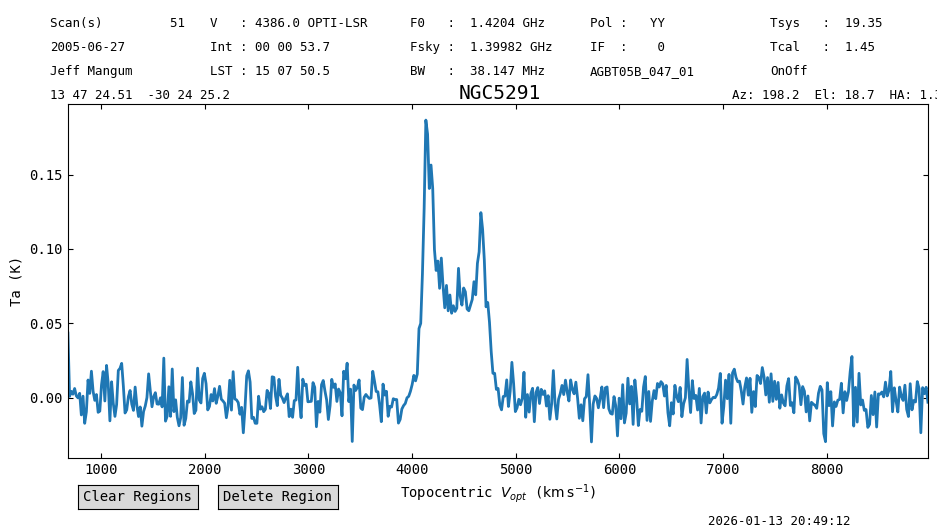

In [39]:
sp1s.plot(xaxis_unit='km/s')

## Final Stats

Finally, at the end we compute some statistics over a spectrum, merely as a checksum if the notebook is reproducable.



In [40]:
sp1s.stats()  # rms 0.02744442 K

{'mean': <Quantity 0.00740813 K>,
 'median': <Quantity 0.00107911 K>,
 'rms': <Quantity 0.02744442 K>,
 'min': <Quantity -0.02971952 K>,
 'max': <Quantity 0.18663077 K>,
 'npt': 500,
 'nan': 0}